# Introduction to the Data Engineering Pipeline Project

In this project, we will design and implement a **robust data pipeline** to process, clean, and analyze data from multiple sources. The project simulates a real-world scenario where an e-commerce company processes large-scale **batch data** for analytics purposes.

### Objective:
- Build an end-to-end **data pipeline** for data ingestion, transformation, storage, and analysis.
- Showcase proficiency in **Python (Pandas)** for data processing and **PostgreSQL** for data storage and querying.
- Ensure **data quality**, **consistency**, and **scalability** throughout the pipeline stages.

### Dataset Overview:
We are provided with **three raw datasets** in CSV format:
1. **transactions.csv**: Contains transactional data, including purchases, quantities, and prices.
2. **users.csv**: Includes customer demographic details such as age, signup date, and location.
3. **products.csv**: Contains product metadata like category, brand, and price.

### Project Goals:
1. **Data Ingestion:** Load raw datasets into Pandas for initial analysis.
2. **Data Transformation:** Clean and transform the datasets to ensure consistency and correctness.
3. **Data Storage:** Store validated data into a PostgreSQL database staging area.
4. **SQL Analysis:** Run analytical SQL queries to derive business insights.
5. **Optimization:** Optimize the data pipeline for better performance.
6. **Documentation:** Provide clear and concise documentation for reproducibility.

Each step will be clearly defined, with actionable tasks, accompanying code, and validation checkpoints to ensure correctness before moving to the next stage.

The following **Table of Contents (TOC)** outlines the key steps in this project.


# Step 1: Data Ingestion Pipeline


---

### 1. Import & Simple EDA
Reads CSV files into Pandas DataFrames for transactions, users, and products.
and show a very simple and well formatted EDA to understand the data.

In [1]:
# Import 
import pandas as pd

# Load datasets 
transactions_df = pd.read_csv('C:/Users/asaye/Documents/Data Engineering/Take Home Assignment/DE Task/DE_demo/data/transactions.csv')
users_df = pd.read_csv('C:/Users/asaye/Documents/Data Engineering/Take Home Assignment/DE Task/DE_demo/data/users.csv')
products_df = pd.read_csv('C:/Users/asaye/Documents/Data Engineering/Take Home Assignment/DE Task/DE_demo/data/products.csv')

# Function to display EDA results in an organized format
def display_eda_summary(df, dataset_name):
    print("="*60) 
    print(f"EDA Summary for Dataset: {dataset_name}")
    print("="*60)
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print("\nColumn Data Types:")
    print(df.dtypes.to_string())
    # Missing values
    print("\nMissing Values (Count & Percentage):")
    missing_values = df.isnull().sum()
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    missing_summary = pd.DataFrame({
        'Missing Count': missing_values,
        'Missing Percentage': missing_percentage
    })
    print(missing_summary.to_string())
    # Statistical summary
    print("\nStatistical Summary (Numerical Columns):")
    print(df.describe().to_string())
    # Display sample rows
    print("\nSample Rows:")
    print(df.head().to_string(index=False))
    print("="*60, "\n")
# Run EDA for each dataset
display_eda_summary(transactions_df, "Transactions")
display_eda_summary(users_df, "Users")
display_eda_summary(products_df, "Products")


EDA Summary for Dataset: Transactions
Shape: 10000 rows × 7 columns

Column Data Types:
TransactionID       object
CustomerID          object
ProductID           object
Category            object
Quantity             int64
Price              float64
TransactionDate     object

Missing Values (Count & Percentage):
                 Missing Count  Missing Percentage
TransactionID                0                 0.0
CustomerID                   0                 0.0
ProductID                    0                 0.0
Category                     0                 0.0
Quantity                     0                 0.0
Price                        0                 0.0
TransactionDate              0                 0.0

Statistical Summary (Numerical Columns):
           Quantity         Price
count  10000.000000  10000.000000
mean       2.979900    255.434608
std        1.409785    141.048821
min        1.000000     10.080000
25%        2.000000    134.727500
50%        3.000000    256.2400

### Convert date columns to datetime format and remove rows with invalid or missing date values
- Converts 'TransactionDate' in `transactions_df` and 'SignupDate' in `users_df` to datetime format.
- Removes rows with invalid or missing date values in both DataFrames.

In [2]:
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'], errors='coerce')
users_df['SignupDate'] = pd.to_datetime(users_df['SignupDate'], errors='coerce')
transactions_df.dropna(subset=['TransactionDate'], inplace=True)
users_df.dropna(subset=['SignupDate'], inplace=True)

In [3]:
# Validate foreign key relationships
valid_customers = set(users_df['CustomerID'])
valid_products = set(products_df['ProductID'])

# Remove invalid foreign key references
transactions_df = transactions_df[
    transactions_df['CustomerID'].isin(valid_customers) &
    transactions_df['ProductID'].isin(valid_products)
]

In [4]:
# Verify column data types
print(transactions_df.dtypes)
print(users_df.dtypes)
print(products_df.dtypes)

# Display final row counts
print(len(transactions_df))
print(len(users_df))
print(len(products_df))

TransactionID              object
CustomerID                 object
ProductID                  object
Category                   object
Quantity                    int64
Price                     float64
TransactionDate    datetime64[ns]
dtype: object
CustomerID            object
Name                  object
Email                 object
Age                    int64
Country               object
SignupDate    datetime64[ns]
dtype: object
ProductID         object
ProductName       object
Category          object
Brand             object
Price            float64
StockQuantity      int64
dtype: object
10000
5000
1000


### Before testing the databae connection lets create the database, the tables and all the roles with privilleges. 
#### Check database connection into PostgreSQL

In [5]:
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Get PostgreSQL configuration from environment variables
DB_USER = os.getenv('POSTGRES_USER')
DB_PASSWORD = os.getenv('POSTGRES_PASSWORD')
DB_HOST = os.getenv('POSTGRES_HOST')
DB_PORT = os.getenv('POSTGRES_PORT')
DB_NAME = os.getenv('POSTGRES_DB')

# Create SQLAlchemy Engine
engine = create_engine(f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')

# Test Connection
try:
    with engine.connect() as connection:
        result = connection.execute(text('SELECT 1;'))
        print("Connection to PostgreSQL is successful.")
except Exception as e:
    print(f"Connection failed: {e}")

Connection to PostgreSQL is successful.


## Now let us load the cleaned dataframes into Postgres Databases
### !!! Before loading the data i have executed the sql file to create the database and the stg_tables.

In [6]:
# Load datasets into PostgreSQL staging tables
try:
    transactions_df.to_sql('stg_transactions', con=engine, if_exists='replace', index=False)
    users_df.to_sql('stg_users', con=engine, if_exists='replace', index=False)
    products_df.to_sql('stg_products', con=engine, if_exists='replace', index=False)
    print("Data loaded into staging tables successfully.")
except Exception as e:
    print(f"Error loading data into staging tables: {e}")


Data loaded into staging tables successfully.


In [7]:
# Verify row counts in staging tables
try:
    with engine.connect() as connection:
        for table in ['stg_transactions', 'stg_users', 'stg_products']:
            result = connection.execute(text(f"SELECT COUNT(*) FROM {table};"))
            count = result.scalar()
            print(f"Table {table} has {count} rows.")
except Exception as e:
    print(f"Error verifying staging table data: {e}")


Table stg_transactions has 10000 rows.
Table stg_users has 5000 rows.
Table stg_products has 1000 rows.


In [8]:
# Preview data from staging tables
try:
    transactions_preview = pd.read_sql_query("SELECT * FROM stg_transactions LIMIT 5", con=engine)
    users_preview = pd.read_sql_query("SELECT * FROM stg_users LIMIT 5", con=engine)
    products_preview = pd.read_sql_query("SELECT * FROM stg_products LIMIT 5", con=engine)

    print("✅ Data preview loaded successfully")
    display(transactions_preview)
    display(users_preview)
    display(products_preview)
except Exception as e:
    print(f"❌ Error previewing data from staging tables: {e}")


✅ Data preview loaded successfully


,TransactionID,CustomerID,ProductID,Category,Quantity,Price,TransactionDate
0,T000001,C3025,P00447,Sports,3,421.00,2024-04-22 10:24:22
1,T000002,C1947,P00707,Groceries,5,274.89,2024-05-03 14:42:23
2,T000003,C2163,P00561,Groceries,1,496.08,2024-06-14 22:07:18
3,T000004,C4859,P00168,Electronics,2,56.75,2024-02-22 02:06:49
4,T000005,C3592,P00806,Groceries,4,205.17,2024-01-01 14:50:28


,CustomerID,Name,Email,Age,Country,SignupDate
0,C0001,Kyle Trevino,wallaceamanda@garcia-kim.com,54,Germany,2020-10-15
1,C0002,Brianna Taylor,danielfisher@gmail.com,45,USA,2021-06-02
2,C0003,Eric Larsen,riverajoshua@davis.com,25,Canada,2021-03-08
3,C0004,Zachary Campbell,robertbrown@clark.com,49,India,2023-04-12
4,C0005,Jesse Cunningham,taylor85@gmail.com,20,Germany,2022-08-24


,ProductID,ProductName,Category,Brand,Price,StockQuantity
0,P00001,Machine,Fashion,Stewart and Sons,560.83,451
1,P00002,Chance,Home Appliances,"Bailey, Martinez and Blair",1480.03,503
2,P00003,Speak,Electronics,"Jenkins, Perry and Cook",261.54,559
3,P00004,Entire,Fashion,Rodriguez Group,1600.32,364
4,P00005,Medical,Sports,Wells-Lee,97.81,32


## On the Postgres part we have loaded and created dimension and fact tables with the correct connection 
### !!! Before loading the data i have executed the sql file to create the database and the stg_tables.

In [9]:
# Verify row counts in analytical tables
try:
    with engine.connect() as connection:
        for table in ['dim_users', 'dim_products', 'fact_transactions']:
            result = connection.execute(text(f"SELECT COUNT(*) FROM {table};"))
            count = result.scalar()
            print(f"Table {table} has {count} rows.")
except Exception as e:
    print(f"Error verifying analytical tables: {e}")


Table dim_users has 5000 rows.
Table dim_products has 1000 rows.
Table fact_transactions has 10000 rows.


In [10]:
# Display sample rows from analytical tables
try:
    with engine.connect() as connection:
        for table in ['dim_users', 'dim_products', 'fact_transactions']:
            result = connection.execute(text(f"SELECT * FROM {table} LIMIT 5;"))
            rows = result.fetchall()
            print(f"Sample data from {table}:")
            for row in rows:
                print(row)
            print("-" * 50)
except Exception as e:
    print(f"Error fetching sample data: {e}")


Sample data from dim_users:
('C4991', 'Brenda Davis', 'vsilva@yahoo.com', 56, 'Australia', datetime.datetime(2021, 7, 4, 0, 0))
('C4374', 'Tony Thomas', 'gina10@gross.com', 25, 'USA', datetime.datetime(2020, 7, 31, 0, 0))
('C4703', 'Monica Beck', 'kayla74@fitzgerald-nicholson.com', 34, 'India', datetime.datetime(2020, 6, 13, 0, 0))
('C0674', 'John Hoffman DDS', 'fscott@newman.com', 63, 'Australia', datetime.datetime(2022, 5, 19, 0, 0))
('C2684', 'Thomas Richardson', 'shall@gmail.com', 52, 'USA', datetime.datetime(2023, 7, 11, 0, 0))
--------------------------------------------------
Sample data from dim_products:
('P00659', 'Card', 'Electronics', 'Howard Ltd', 1113.43, 706)
('P00540', 'Anything', 'Books', 'Gardner, James and Wright', 880.6, 75)
('P00564', 'Seven', 'Books', 'Kennedy, Nelson and Nguyen', 1918.13, 140)
('P00091', 'Hospital', 'Books', 'Harrison and Sons', 1973.33, 339)
('P00819', 'I', 'Home Appliances', 'Elliott, Carter and Rose', 1818.85, 471)
----------------------------

In [11]:
# Validate referential integrity in fact_transactions 
try:
    with engine.connect() as connection:
        result = connection.execute(text("""
            SELECT COUNT(*) 
            FROM fact_transactions ft
            LEFT JOIN dim_users du ON ft."CustomerID" = du."CustomerID"
            LEFT JOIN dim_products dp ON ft."ProductID" = dp."ProductID"
            WHERE du."CustomerID" IS NULL OR dp."ProductID" IS NULL;
        """))
        count = result.scalar()
        if count == 0:
            print("All relationships in fact_transactions are valid.")
        else:
            print(f"{count} invalid relationship(s) found in fact_transactions.")
except Exception as e:
    print(f"Error validating relationships: {e}")


All relationships in fact_transactions are valid.


In [12]:
# Inspect column data types
try:
    with engine.connect() as connection:
        for table in ['dim_users', 'dim_products', 'fact_transactions']:
            result = connection.execute(text(f"""
                SELECT column_name, data_type 
                FROM information_schema.columns 
                WHERE table_name = '{table}';
            """))
            print(f"Column types for {table}:")
            for row in result.fetchall():
                print(row)
            print("-" * 50)
except Exception as e:
    print(f"Error inspecting column types: {e}")


Column types for dim_users:
('Age', 'bigint')
('SignupDate', 'timestamp without time zone')
('CustomerID', 'text')
('Name', 'text')
('Email', 'text')
('Country', 'text')
--------------------------------------------------
Column types for dim_products:
('Price', 'double precision')
('StockQuantity', 'bigint')
('ProductID', 'text')
('ProductName', 'text')
('Category', 'text')
('Brand', 'text')
--------------------------------------------------
Column types for fact_transactions:
('TransactionDate', 'timestamp without time zone')
('customerage', 'bigint')
('Quantity', 'bigint')
('Price', 'double precision')
('TransactionID', 'text')
('productbrand', 'text')
('CustomerID', 'text')
('ProductID', 'text')
('productcategory', 'text')
--------------------------------------------------


In [13]:
# Define SQL queries for analysis
analysis_queries = {
    "top_5_products_quantity": """
        SELECT p."ProductName", SUM(f."Quantity") AS total_quantity
        FROM fact_transactions f
        JOIN dim_products p ON f."ProductID" = p."ProductID"
        GROUP BY p."ProductName"
        ORDER BY total_quantity DESC
        LIMIT 5;
    """,
    "top_5_products_revenue": """
        SELECT p."ProductName", SUM(f."Quantity" * f."Price") AS total_revenue
        FROM fact_transactions f
        JOIN dim_products p ON f."ProductID" = p."ProductID"
        GROUP BY p."ProductName"
        ORDER BY total_revenue DESC
        LIMIT 5;
    """,
    "customer_age_segmentation": """
        SELECT u."Age", COUNT(*) AS customer_count
        FROM dim_users u
        GROUP BY u."Age"
        ORDER BY customer_count DESC;
    """,
    "monthly_sales_trends": """
        SELECT DATE_TRUNC('month', f."TransactionDate") AS sales_month, SUM(f."Quantity" * f."Price") AS monthly_revenue
        FROM fact_transactions f
        GROUP BY sales_month
        ORDER BY sales_month;
    """,
    "top_customers_spending": """
        SELECT u."Name", SUM(f."Quantity" * f."Price") AS total_spending
        FROM fact_transactions f
        JOIN dim_users u ON f."CustomerID" = u."CustomerID"
        GROUP BY u."Name"
        ORDER BY total_spending DESC
        LIMIT 5;
    """
}

# Execute analysis queries and load results into Pandas DataFrames
analysis_results = {}
try:
    with engine.connect() as connection:
        for analysis, query in analysis_queries.items():
            df = pd.read_sql_query(text(query), connection)
            analysis_results[analysis] = df
            print(f"{analysis} query executed successfully.")
except Exception as e:
    print(f"Error executing analysis queries: {e}")


top_5_products_quantity query executed successfully.
top_5_products_revenue query executed successfully.
customer_age_segmentation query executed successfully.
monthly_sales_trends query executed successfully.
top_customers_spending query executed successfully.


In [14]:
# Display analysis results
for analysis, df in analysis_results.items():
    print(f"\n{analysis.replace('_', ' ').title()} Results:")
    print(df.head())



Top 5 Products Quantity Results:
  ProductName  total_quantity
0         Low           248.0
1      Action           168.0
2   Everybody           166.0
3     Success           153.0
4       Begin           149.0

Top 5 Products Revenue Results:
  ProductName  total_revenue
0         Low       59313.89
1   Everybody       45266.40
2      Action       41907.21
3     Success       37368.11
4       Begin       36679.99

Customer Age Segmentation Results:
   Age  customer_count
0   26             135
1   50             134
2   22             124
3   63             122
4   55             120

Monthly Sales Trends Results:
  sales_month  monthly_revenue
0  2023-12-01        192166.17
1  2024-01-01        681356.31
2  2024-02-01        582844.85
3  2024-03-01        613422.38
4  2024-04-01        672259.72

Top Customers Spending Results:
               Name  total_spending
0   Daniel Williams        11348.10
1          Dawn Fry         9139.47
2  Christopher Cruz         9057.48
3  Emily Ri

C:\Users\asaye\AppData\Local\Temp\ipykernel_19924\3744153662.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


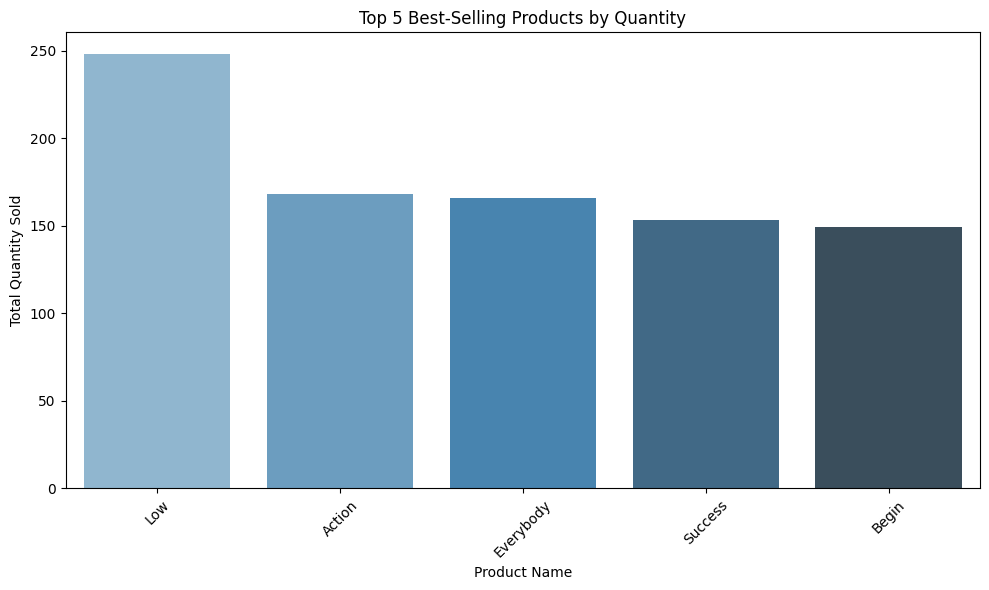

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization: Top 5 Best-Selling Products by Quantity
top_products_qty = analysis_results['top_5_products_quantity']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_products_qty,
    x='ProductName',
    y='total_quantity',
    palette='Blues_d'
)
plt.title('Top 5 Best-Selling Products by Quantity')
plt.xlabel('Product Name')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\asaye\AppData\Local\Temp\ipykernel_19924\3090157324.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


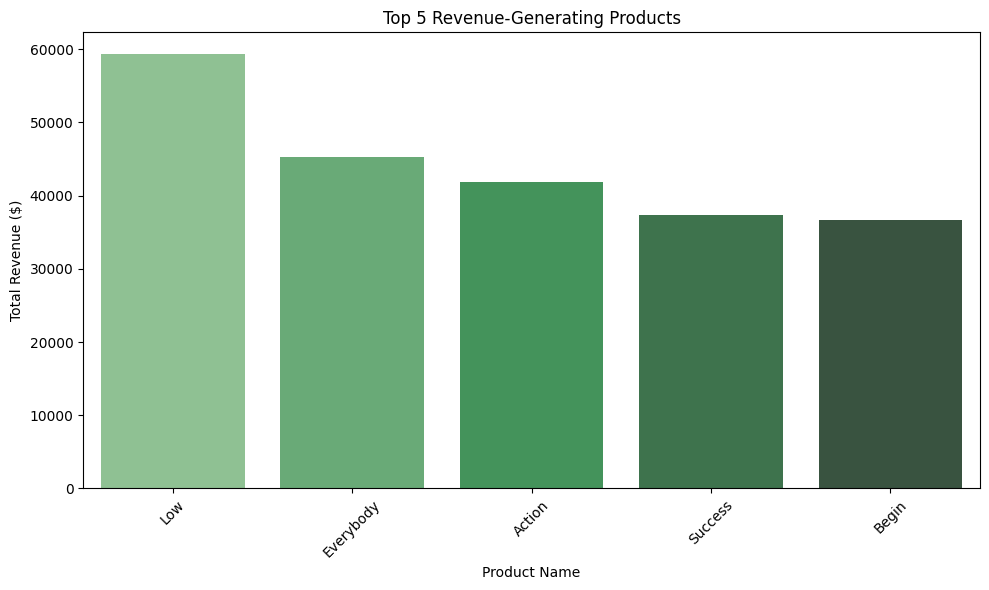

In [16]:
# Visualization: Top 5 Products by Revenue
top_products_rev = analysis_results['top_5_products_revenue']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_products_rev,
    x='ProductName',
    y='total_revenue',
    palette='Greens_d'
)
plt.title('Top 5 Revenue-Generating Products')
plt.xlabel('Product Name')
plt.ylabel('Total Revenue ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\asaye\AppData\Local\Temp\ipykernel_19924\902196283.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


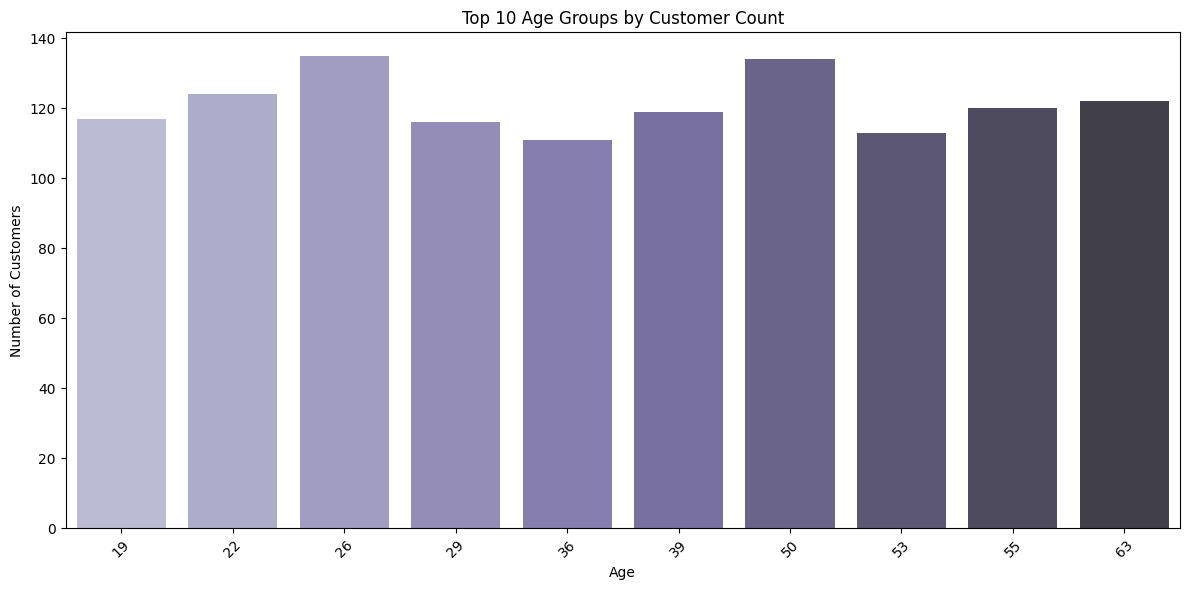

In [17]:
# Visualization: Customer Age Segmentation
customer_age_segmentation = analysis_results['customer_age_segmentation']

plt.figure(figsize=(12, 6))
sns.barplot(
    data=customer_age_segmentation.sort_values(by='customer_count', ascending=False).head(10),
    x='Age',
    y='customer_count',
    palette='Purples_d'
)
plt.title('Top 10 Age Groups by Customer Count')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


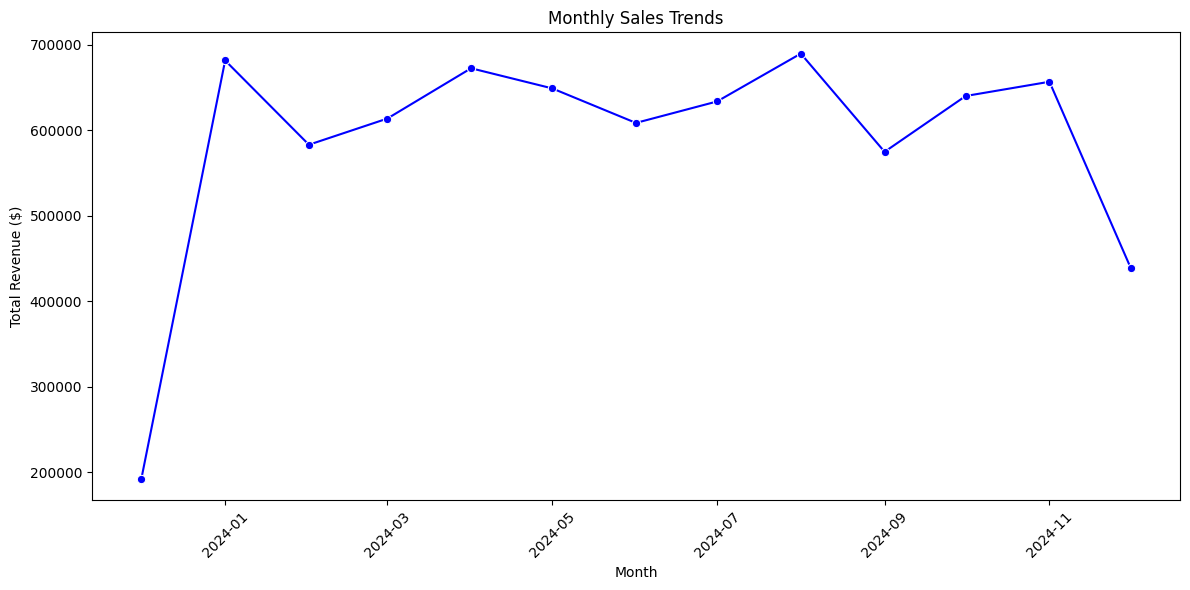

In [18]:
# Visualization: Monthly Sales Trends
monthly_sales = analysis_results['monthly_sales_trends']

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=monthly_sales,
    x='sales_month',
    y='monthly_revenue',
    marker='o',
    color='b'
)
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Revenue ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
